In [1]:
import torch.random

from kan import *
from sklearn.metrics import f1_score
from sklearn.utils import compute_class_weight

mse = lambda x, y: torch.mean((x - y) ** 2)

np.random.seed(0)

def get_f1(y, logits):
    logits = torch.softmax(logits, dim=1).detach().numpy().argmax(axis=1)
    y = y.squeeze().detach().numpy()
    return f1_score(y, logits, average="macro")

f1 = lambda x: (torch.abs(x[:, [0]]) > torch.abs(x[:, [1]])).long() + (x[:, [0]] > x[:, [1]]).long()
f2 = lambda x: torch.zeros(x.shape[0], 1).long()
f3 = lambda x: (torch.sin(4 * x[:, [0]]) > 0).long() + (torch.sin(4 * x[:, [1]]) > 0).long()
f4 = lambda x: torch.ones(x.shape[0], 1).long()
f5 = lambda x: torch.ones(x.shape[0], 1).long() + 1
datasets = ([create_dataset(f1, n_var=3, train_num=80, test_num=20, seed=i) for i in range(0, 5)] +
            [create_dataset(f2, n_var=3, train_num=80, test_num=20, seed=i) for i in range(5, 10)] +
            [create_dataset(f3, n_var=3, train_num=80, test_num=20, seed=i) for i in range(20, 15)] +
            [create_dataset(f4, n_var=3, train_num=80, test_num=20, seed=i) for i in range(15, 20)] +
            [create_dataset(f5, n_var=3, train_num=80, test_num=20, seed=i) for i in range(20, 25)])
letters = [chr(i) for i in range(65, 73)]
pairs = list(set([tuple(x) for x in np.random.choice(letters, (100, 2), replace=True)]))[:25]

def get_pandas(dataset, c, d):
    X_train = pd.DataFrame(dataset["train_input"].detach().numpy(), columns=["x1", "x2", "dummy"])
    y_train = pd.Series(dataset["train_label"].detach().numpy()[:, 0])
    X_test = pd.DataFrame(dataset["test_input"].detach().numpy(), columns=["x1", "x2", "dummy"])
    y_test = pd.Series(dataset["test_label"].detach().numpy()[:, 0])
    def get_cat(X):
        X["cA"] = c
        X["cB"] = d
    get_cat(X_train)
    get_cat(X_test)
    return X_train, y_train, X_test, y_test

data = [get_pandas(dataset, pair[0], pair[1]) for dataset, pair in zip(datasets, pairs)]
X_train, y_train, X_test, y_test = zip(*data)
X_train = pd.concat(X_train)
y_train = pd.concat(y_train)
X_test = pd.concat(X_test)
y_test = pd.concat(y_test)
X_train = X_train.sample(frac=1, random_state=0).reset_index(drop=True)
y_train = y_train.sample(frac=1, random_state=0).reset_index(drop=True)
X_test = X_test.sample(frac=1, random_state=1).reset_index(drop=True)
y_test = y_test.sample(frac=1, random_state=1).reset_index(drop=True)
X_test["cA"].iloc[:5] = np.nan
X_test[["cA", "cB"]].iloc[5:10] = np.nan
X_test["cB"].iloc[10:15] = np.nan
X_train = X_train.sample(frac=1, random_state=2).reset_index(drop=True)
y_train = y_train.sample(frac=1, random_state=2).reset_index(drop=True)
X_test = X_test.sample(frac=1, random_state=3).reset_index(drop=True)
y_test = y_test.sample(frac=1, random_state=3).reset_index(drop=True)
pd.concat([X_test, y_test], axis=1).sample(frac=1, random_state=0)

/tmp/ipykernel_7290/2780653128.py:51: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_test["cA"].iloc[:5] = np.nan
/tmp/ipykernel_7290/2780653128.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,x1,x2,dummy,cA,cB,0
132,-0.053532,-0.639214,-0.239264,A,B,1
309,-0.539523,-0.964262,-0.668778,C,F,2
341,-0.106738,0.973118,0.221132,A,F,0
196,-0.793743,-0.274153,0.190396,C,A,1
246,-0.037155,0.924490,0.623433,G,G,1
...,...,...,...,...,...,...
323,0.317371,-0.426030,0.495181,A,C,2
192,0.038267,-0.785166,0.676372,C,F,2
117,-0.375355,0.799322,-0.013825,E,H,2
47,-0.913399,0.778205,0.405787,A,C,2


In [2]:
print(y_train.value_counts())
pd.concat([X_train[['cA', 'cB']], y_train], axis=1).value_counts()

1    596
0    510
2    494
Name: count, dtype: int64


cA  cB  0
A   B   1    80
C   D   1    80
F   F   0    80
    C   1    80
    B   0    80
E   H   2    80
D   G   0    80
    D   2    80
    A   2    80
A   C   2    80
C   F   2    80
G   G   1    80
C   A   1    80
A   D   0    80
    F   0    80
B   C   1    41
F   D   1    40
A   E   1    39
C   G   1    39
F   A   1    37
A   E   0    25
F   A   0    24
C   G   0    22
F   D   0    22
B   C   2    22
F   A   2    19
C   G   2    19
F   D   2    18
B   C   0    17
A   E   2    16
Name: count, dtype: int64

[9, 5, 10, 3]


train loss: 4.71e-01 | test loss: 4.64e-01 | reg: 9.22e+00 : 100%|████| 1/1 [00:06<00:00,  6.56s/it]


New best score: 0.48349430043197633 (iter 0) with loss 0.4637932942963199


train loss: 4.54e-01 | test loss: 4.45e-01 | reg: 9.50e+00 : 100%|████| 1/1 [00:03<00:00,  3.54s/it]
train loss: 3.94e-01 | test loss: 4.01e-01 | reg: 1.13e+01 : 100%|████| 1/1 [00:03<00:00,  3.26s/it]


New best score: 0.5628495458977453 (iter 2) with loss 0.4005872898743189


train loss: 3.42e-01 | test loss: 3.51e-01 | reg: 1.22e+01 : 100%|████| 1/1 [00:03<00:00,  3.36s/it]


New best score: 0.6015474497957377 (iter 3) with loss 0.35083197210835915


train loss: 2.71e-01 | test loss: 2.89e-01 | reg: 1.31e+01 : 100%|████| 1/1 [00:03<00:00,  3.24s/it]


New best score: 0.6447272702342234 (iter 4) with loss 0.28855319991170153


train loss: 2.43e-01 | test loss: 2.53e-01 | reg: 1.30e+01 : 100%|████| 1/1 [00:03<00:00,  3.51s/it]


New best score: 0.7131077057343805 (iter 5) with loss 0.25273541692893653


train loss: 2.23e-01 | test loss: 2.29e-01 | reg: 1.24e+01 : 100%|████| 1/1 [00:03<00:00,  3.78s/it]


New best score: 0.7654353014311973 (iter 6) with loss 0.22881752851771409


train loss: 2.15e-01 | test loss: 2.21e-01 | reg: 1.23e+01 : 100%|████| 1/1 [00:03<00:00,  3.18s/it]


New best score: 0.7947100635347369 (iter 7) with loss 0.22077822816767345


train loss: 2.03e-01 | test loss: 2.10e-01 | reg: 1.21e+01 : 100%|████| 1/1 [00:03<00:00,  3.15s/it]


New best score: 0.8124157985732053 (iter 8) with loss 0.2097762862389672


train loss: 1.83e-01 | test loss: 1.93e-01 | reg: 1.22e+01 : 100%|████| 1/1 [00:03<00:00,  3.54s/it]


New best score: 0.8332056044647015 (iter 9) with loss 0.19323043049926755


train loss: 1.68e-01 | test loss: 1.82e-01 | reg: 1.31e+01 : 100%|████| 1/1 [00:03<00:00,  3.75s/it]


New best score: 0.8542532157584288 (iter 10) with loss 0.18173754846339119


train loss: 1.63e-01 | test loss: 1.78e-01 | reg: 1.30e+01 : 100%|████| 1/1 [00:03<00:00,  3.73s/it]
train loss: 1.63e-01 | test loss: 1.78e-01 | reg: 1.30e+01 : 100%|████| 1/1 [00:03<00:00,  3.41s/it]
train loss: 1.63e-01 | test loss: 1.78e-01 | reg: 1.30e+01 : 100%|████| 1/1 [00:03<00:00,  3.44s/it]
train loss: 1.63e-01 | test loss: 1.78e-01 | reg: 1.30e+01 : 100%|████| 1/1 [00:03<00:00,  3.29s/it]
train loss: 1.64e-01 | test loss: 1.78e-01 | reg: 1.29e+01 : 100%|████| 1/1 [00:03<00:00,  3.46s/it]
train loss: 1.64e-01 | test loss: 1.78e-01 | reg: 1.29e+01 : 100%|████| 1/1 [00:03<00:00,  3.19s/it]
train loss: 1.64e-01 | test loss: 1.78e-01 | reg: 1.29e+01 : 100%|████| 1/1 [00:03<00:00,  3.07s/it]
train loss: 1.64e-01 | test loss: 1.78e-01 | reg: 1.29e+01 : 100%|████| 1/1 [00:05<00:00,  5.03s/it]
train loss: 1.64e-01 | test loss: 1.78e-01 | reg: 1.29e+01 : 100%|████| 1/1 [00:03<00:00,  3.29s/it]
/home/christophercoffee/PycharmProjects/pykan/venv/lib/python3.10/site-packages/IPython/cor

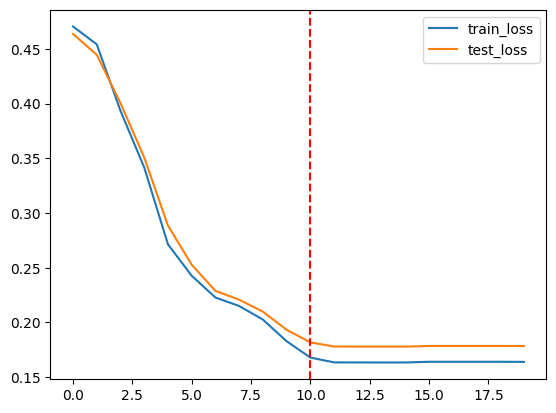

CatLinKAN(
  (biases): ModuleList(
    (0): Linear(in_features=3, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): Identity(in_features=1, out_features=1, bias=True)
    )
  )
  (base_fun): Identity(in_features=1, out_features=1, bias=True)
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
  (mini_kan): KAN(
    (biases): ModuleList(
      (0): Linear(in_features=5, out_features=1, bias=False)
    )
    (act_fun): ModuleList(
      (0): KANLayer(
        (base_fun): Identity(in_features=1, out_features=1, bias=True)
      )
    )
    (base_fun): Identity(in_features=1, out_features=1, bias=True)
    (symbolic_fun): ModuleList(
      (0): Symbolic_KANLayer()
    )
  )
  (embeddings): ModuleDict(
    (cA): Embedding(8, 3, scale_grad_by_freq=True)
    (cB): Embedding(9, 3, scale_grad_by_freq=True)
  )
  (hidden): ParametrizedLinear(
    in_features=5, out_features=10, bias=False
    (parametrizations): ModuleDict(
      (weight): P

In [3]:
class FocalLoss(nn.Module):
    def __init__(self, y_train, beta=1.0, gamma=2.0):
        super().__init__()
        self.alpha = torch.tensor(compute_class_weight("balanced",
                                                       classes=np.array(range(3)),
                                                       y=y_train)) ** beta
        self.gamma = gamma

    def forward(self, input: torch.tensor, target: torch.tensor):
        ce_loss = nn.functional.cross_entropy(input, target, reduction="none")
        focal_loss = self.alpha[target] * (1 - torch.exp(-ce_loss)) ** self.gamma * ce_loss
        return torch.mean(focal_loss)
        
model = CatLinKAN(X_train, include_linear=True, width=[5,10,3], grid=5, k=3, seed=0, base_fun=Identity())
train_input, train_label = model.init_data(X_train, y_train)
test_input, test_label = model.init_data(X_test, y_test)

params = {"dataset": {"train_input": train_input, "train_label": train_label, "test_input": test_input, "test_label": test_label},
          'loss_fn': FocalLoss(y_train), "steps": 1, "lamb": 0.01}

train_model(model, params, get_f1, opt='LBFGS', lr=0.01, plot=True, iters=20, log=1)

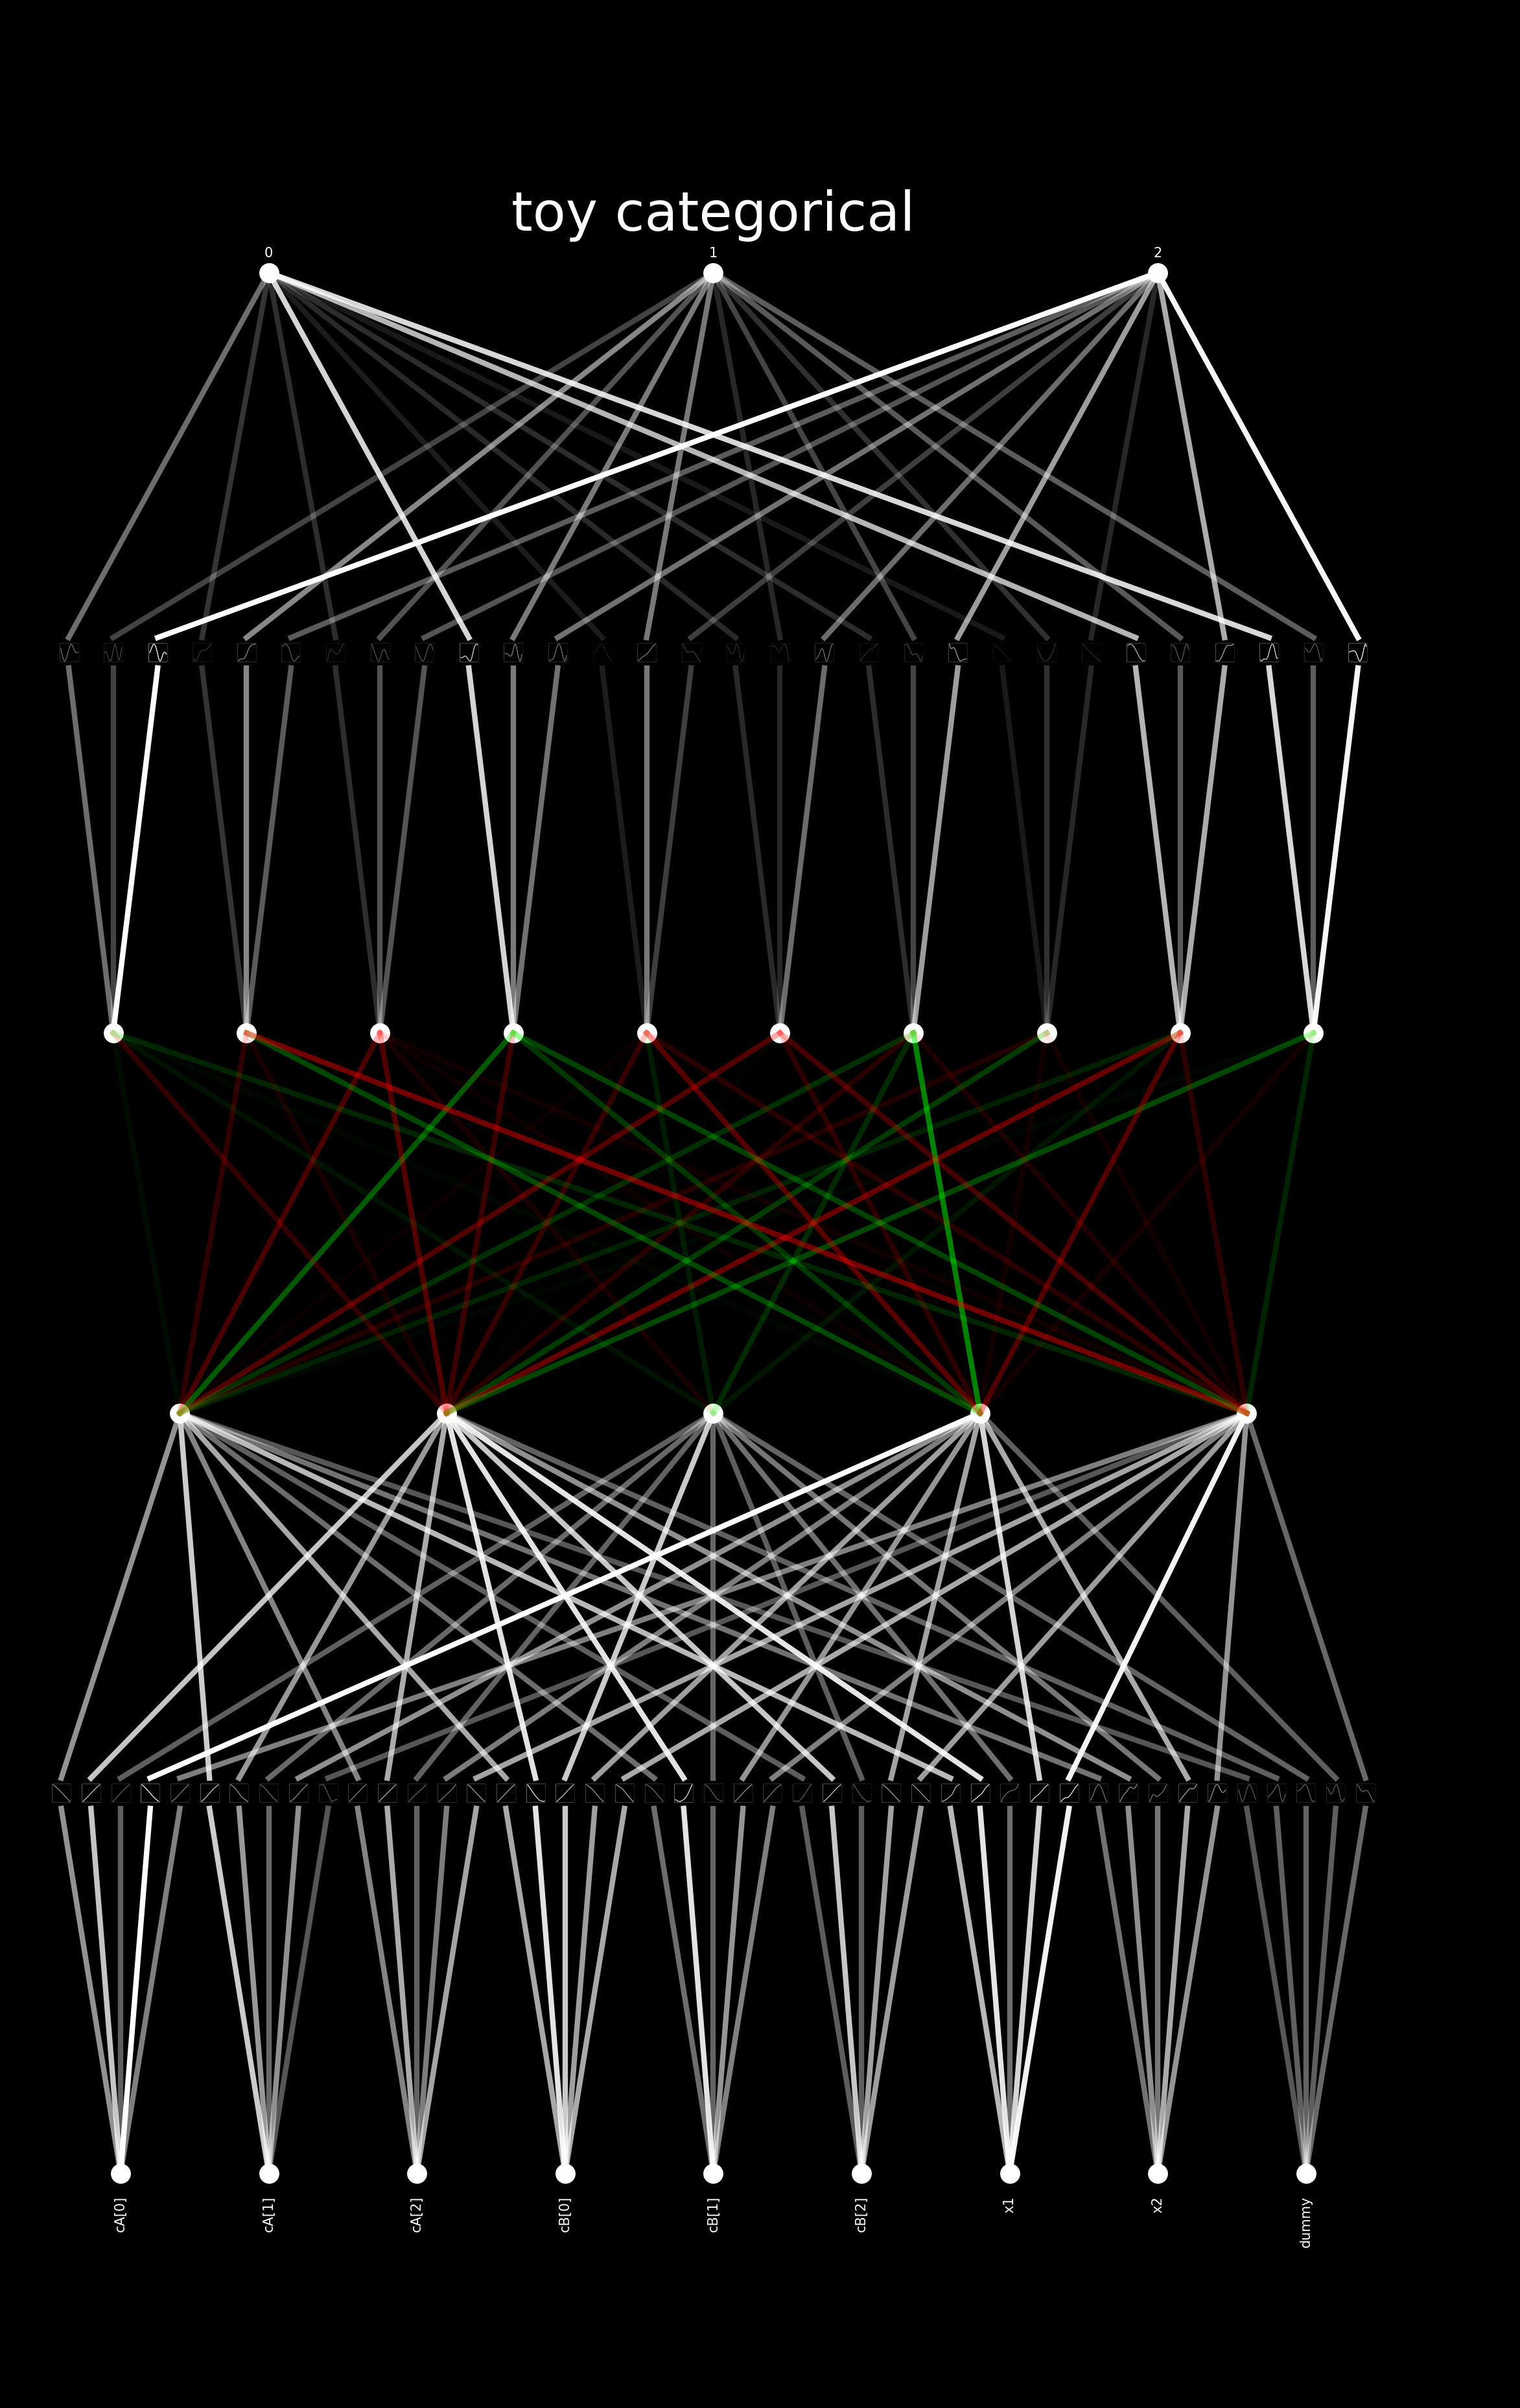

In [4]:
model(train_input)
model.plot(title="toy categorical", scale=3, out_vars=list(range(3)))
plt.savefig("catlinkan_classification.png", dpi=400, bbox_inches="tight")
plt.show()

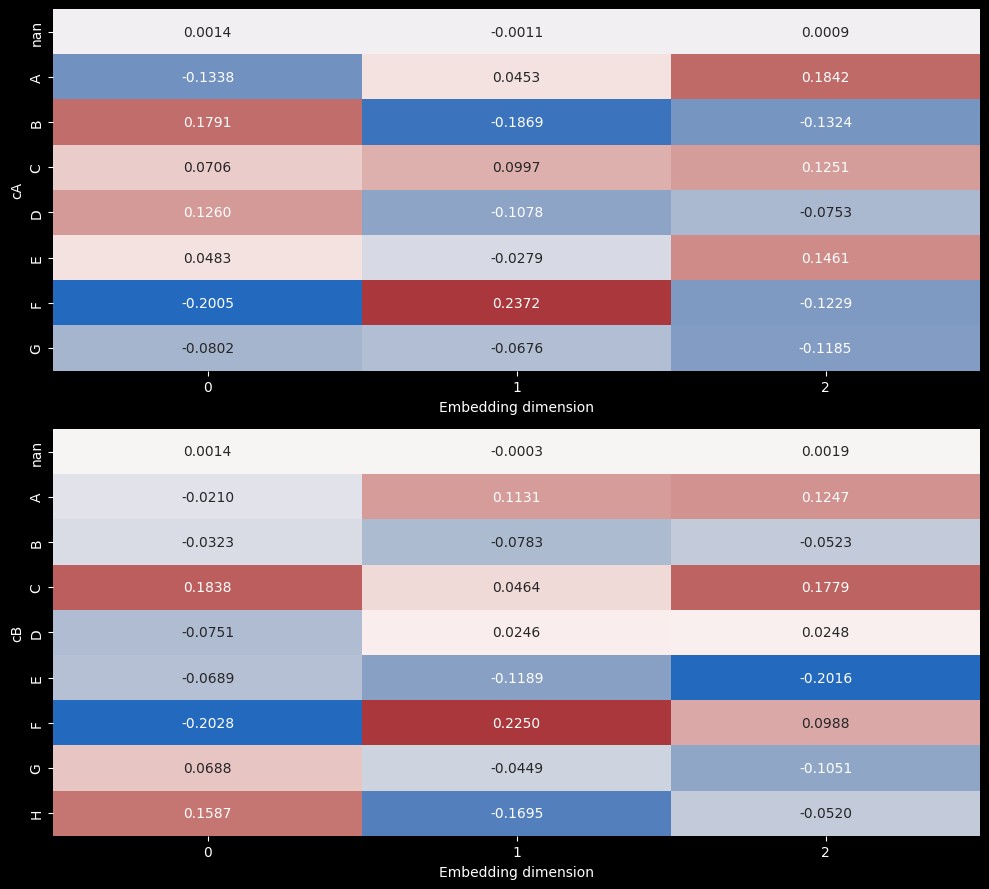

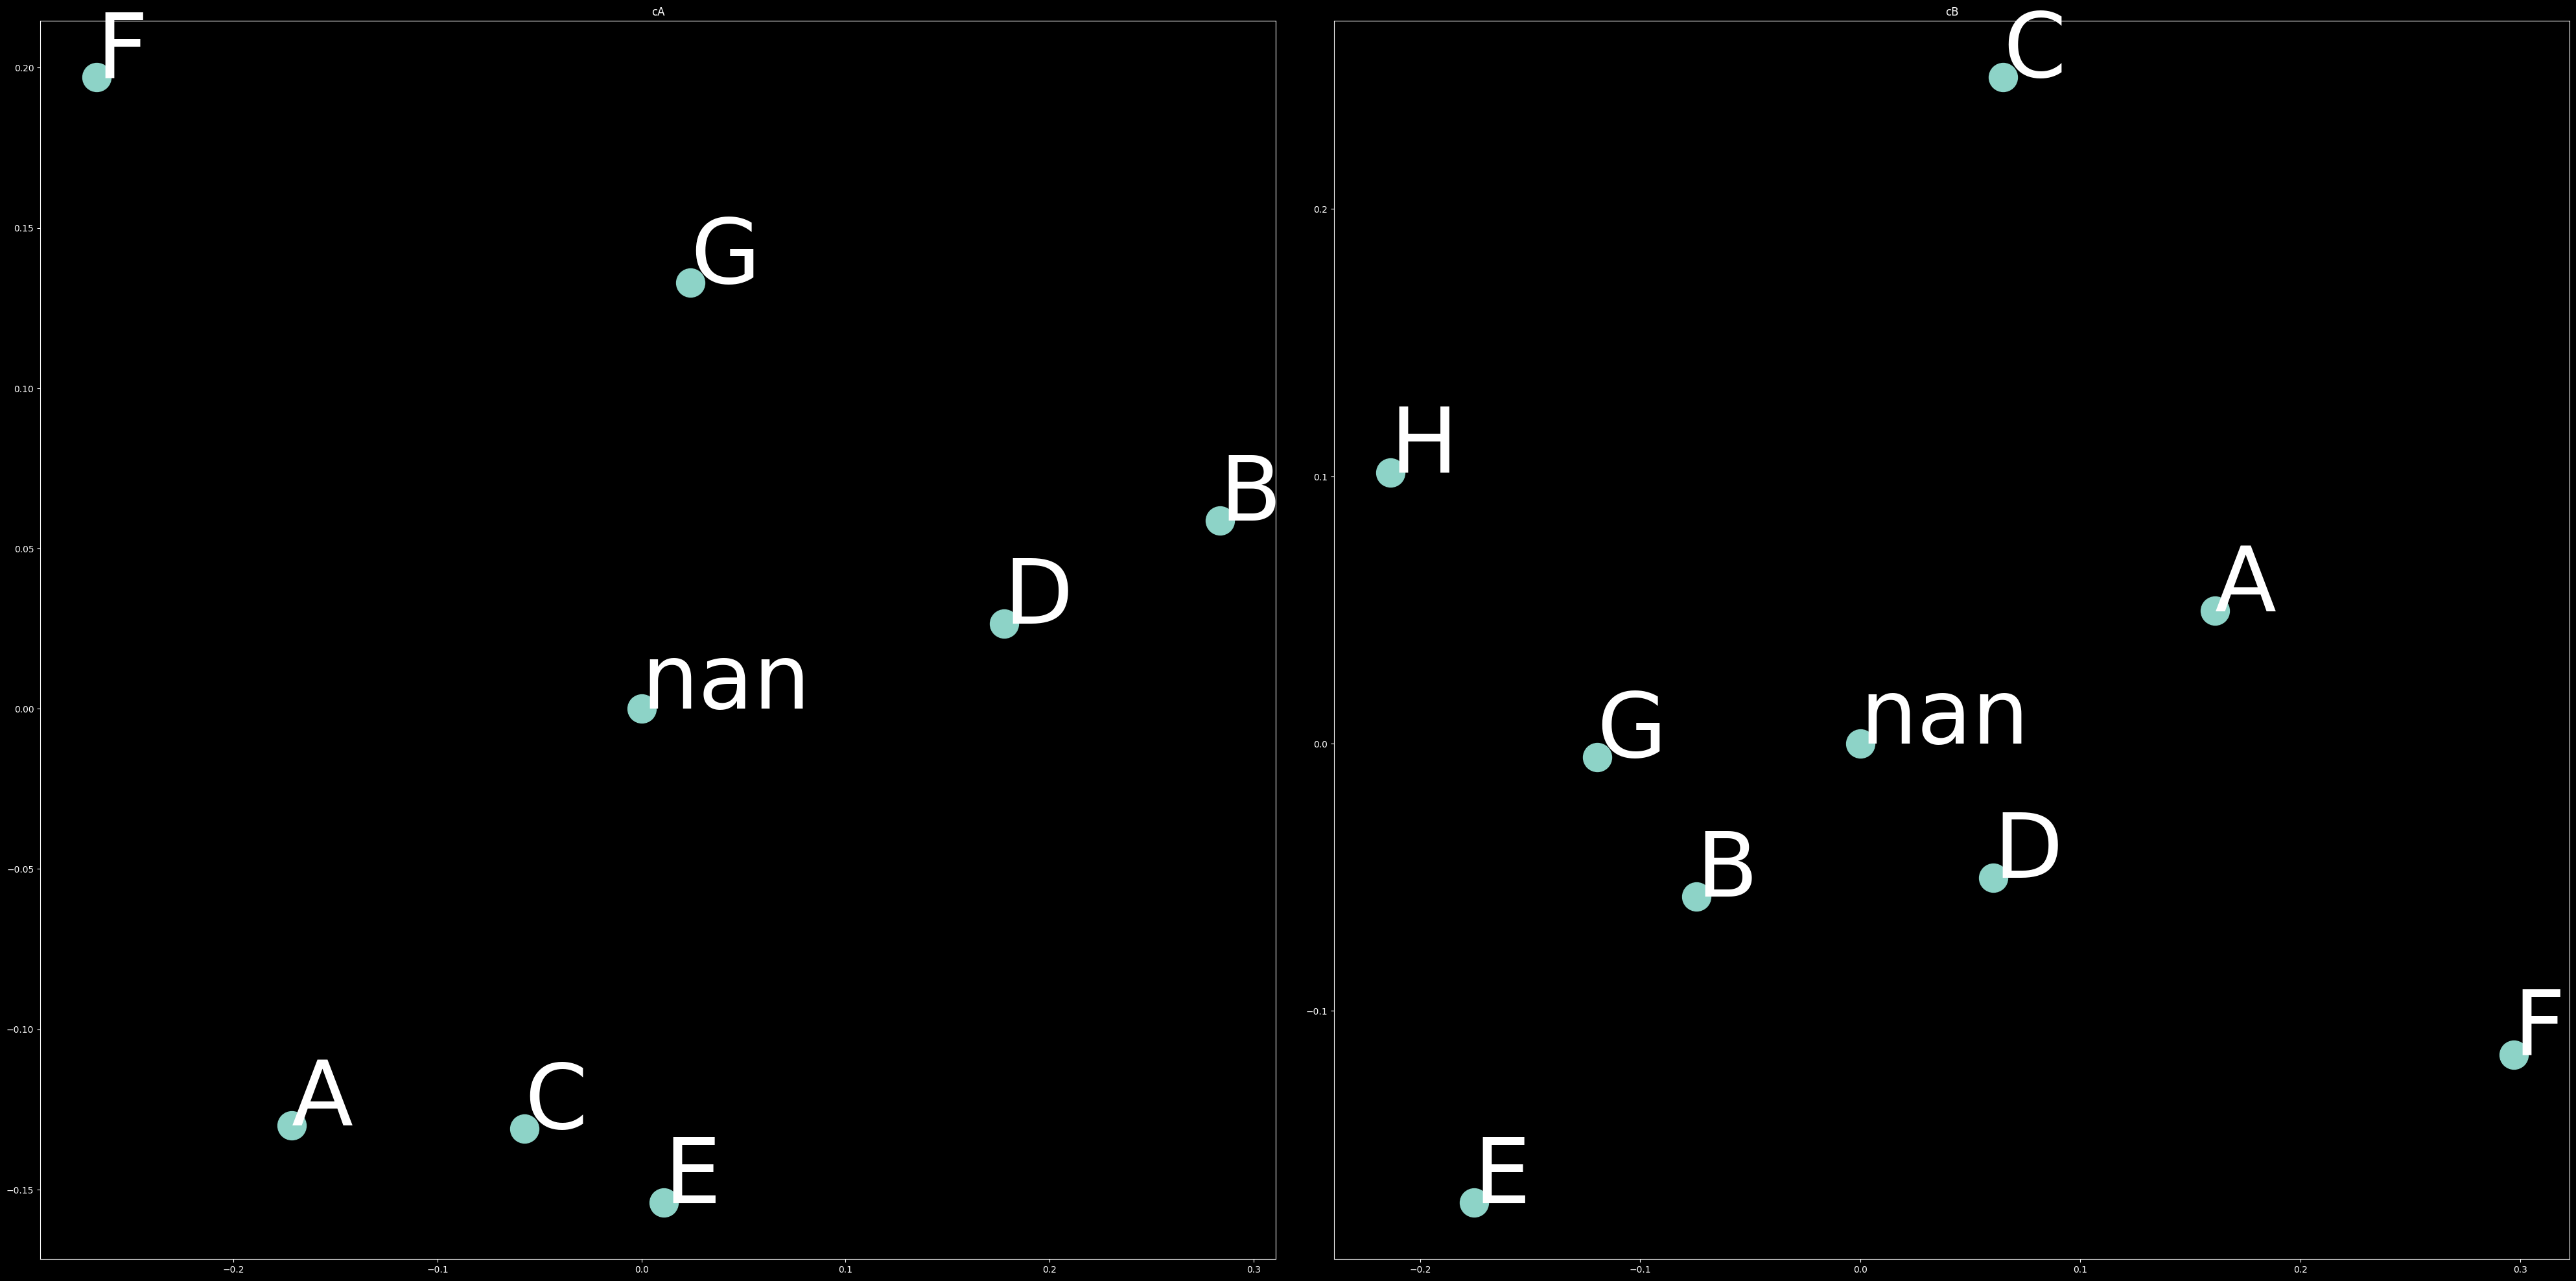

In [5]:
model.plot_embeddings()